# Hyperparameter Scan

Simple hyperparameter scan for Latentbits and number of layers on MNIST

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import tensorflow as tf
import tensorflow_quantum as tfq
from hep_VQAE import data_preprocessing as dp


import warnings
warnings.filterwarnings('ignore')

2022-07-01 00:18:49.019348: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-01 00:18:49.019415: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-07-01 00:18:55.784010: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-01 00:18:55.784114: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-01 00:18:55.784156: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tomskopfbahnhof): /proc/driver/nvidia/version does not exist
2022-07-01 00:18:55.784631: I tensorflow/core/platform/cpu_fe

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train/255.0, x_test/255.0

In [3]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


In [4]:
DOWNSCALE = 2
DATA_DIMENSION = DOWNSCALE*DOWNSCALE
LATENT_BITS = 1

x_train, x_test = dp.PCA_reduce(x_train, DATA_DIMENSION, val_data=x_test)

In [5]:
x_train_threes = x_train[y_train==True]
x_train = x_train[y_train==False]

x_test_threes = x_test[y_test==True]
x_test = x_test[y_test==False]

Build models with different parameters. Additionally safe parameter configurations for later reference

In [6]:
from hep_VQAE import QAE as qae

models = []
hyperspace = []
latent_bit_poss = [1, 2]
layer_poss = [1,2,3,4,5,6,7,8]

from itertools import product

for i, j in product(latent_bit_poss, layer_poss):
    model = qae.SQAE_model(4,i,j)
    models.append(model)
    hyperspace.append((i,j))

Since input states depend on number of latent bits, states need to be prepared seperately

(could be simplified since number of layers does not change input state)

In [7]:
trains = []
tests = []

trains_threes = []
tests_threes = []

for params in hyperspace:
    latent_space, _ = params
    x_train_circuit = [dp.input_states_SQAE(x,DATA_DIMENSION,latent_space) for x in x_train]
    x_test_circuit = [dp.input_states_SQAE(x,DATA_DIMENSION,latent_space) for x in x_test]

    x_train_circuit_threes = [dp.input_states_SQAE(x,DATA_DIMENSION,latent_space) for x in x_train_threes]
    x_test_circuit_threes = [dp.input_states_SQAE(x,DATA_DIMENSION,latent_space) for x in x_test_threes]

    x_train_tf = tfq.convert_to_tensor(x_train_circuit)
    x_test_tf = tfq.convert_to_tensor(x_test_circuit)

    x_train_tf_threes = tfq.convert_to_tensor(x_train_circuit_threes)
    x_test_tf_threes = tfq.convert_to_tensor(x_test_circuit_threes)
    
    trains.append(x_train_tf)
    tests.append(x_test_tf)
    
    trains_threes.append(x_train_tf_threes)
    tests_threes.append(x_test_tf_threes)

In [8]:
for model in models:
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.1))

In [9]:
y_train_ones = np.ones(shape=len(x_train_tf))
y_test_ones = np.ones(shape=len(x_test_tf))

y_train_ones_threes = np.ones(shape=len(x_train_tf_threes))
y_test_ones_threes = np.ones(shape=len(x_test_tf_threes))

Train all models and safe all histories

In [10]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
histories = []
for index, model in enumerate(models):
    x_train_tf = trains[index]
    x_test_tf = tests[index]
    print("Training model with: ", hyperspace[index])
    history = model.fit(x_train_tf, y_train_ones, epochs=50, batch_size=64, validation_data=(x_test_tf, y_test_ones), callbacks=[es])
    histories.append(history)

Training model with:  (1, 1)
Epoch 1/50
93/93 [==============================] - 4s 38ms/step - loss: 0.7488 - val_loss: 0.7286
Epoch 2/50
93/93 [==============================] - 3s 34ms/step - loss: 0.7466 - val_loss: 0.7287
Epoch 3/50
93/93 [==============================] - 3s 33ms/step - loss: 0.7463 - val_loss: 0.7300
Epoch 4/50
93/93 [==============================] - 3s 34ms/step - loss: 0.7466 - val_loss: 0.7288
Epoch 5/50
93/93 [==============================] - 3s 34ms/step - loss: 0.7466 - val_loss: 0.7284
Epoch 6/50
93/93 [==============================] - 3s 33ms/step - loss: 0.7463 - val_loss: 0.7276
Epoch 7/50
93/93 [==============================] - 3s 32ms/step - loss: 0.7465 - val_loss: 0.7285
Epoch 8/50
93/93 [==============================] - 3s 31ms/step - loss: 0.7464 - val_loss: 0.7279
Epoch 9/50
93/93 [==============================] - 3s 32ms/step - loss: 0.7464 - val_loss: 0.7292
Epoch 10/50
93/93 [==============================] - 3s 35ms/step - loss: 0.7464

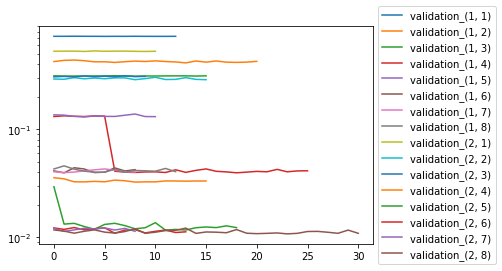

In [11]:
for i,hist in enumerate(histories):
    #plt.plot(i.history['loss'], label="training")
    plt.plot(hist.history['val_loss'], label="validation_"+str(hyperspace[i]))
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [12]:
def acc_for_threshold(T, predsix, predthree):
    # sixes that are predicted six
    num_six_right = np.sum(predsix > T)
    # threes that are predicted three
    num_three_right = np.sum(predthree < T)
    acc = (num_six_right + num_three_right)/(len(pred_six) + len(pred_three))
    return acc


See tagging curve for all models.

(1, 1) 0.6026422764227642
(1, 2) 0.9486788617886179
(1, 3) 0.9141260162601627
(1, 4) 0.8978658536585366
(1, 5) 0.975609756097561
(1, 6) 0.8866869918699187
(1, 7) 0.913109756097561
(1, 8) 0.9222560975609756
(2, 1) 0.7149390243902439
(2, 2) 0.5873983739837398
(2, 3) 0.7728658536585366
(2, 4) 0.8561991869918699
(2, 5) 0.9552845528455285
(2, 6) 0.9527439024390244
(2, 7) 0.9629065040650406
(2, 8) 0.9563008130081301


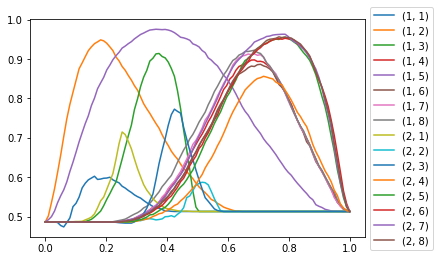

In [13]:
for i, model in enumerate(models):
    pred_six = model.predict(tests[i])
    #print(np.median(pred_six))
    pred_three = model.predict(tests_threes[i])
    #print(np.median(pred_three))

    Ts = np.linspace(0,1,100)
    accs = []
    for j in Ts:
        accs.append(acc_for_threshold(j, pred_six, pred_three))
    print(hyperspace[i], max(accs))
    plt.plot(Ts, accs, label=str(hyperspace[i]))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))